### Using Ensamble Emperical Model Decomposition method to decompose the Sea Surface Temperature Signal into intrinsic model functions components. Aim is to reduce the heavy load of MUR data and instead using the derived values to train the model. 
##### Author : Chandrama Sarker
#### Ref. https://github.com/laszukdawid/PyEMD; Intro — PyEMD 0.4.0 documentation (https://pyemd.readthedocs.io/en/latest/intro.html)

#### Note -  I was not successful to test this decomposed signals onto a simple model. Somehow with the input shape used to train the model I am having problem. I am trying to develop a simple regression model if I could be able to finish by tomorrow. 

In [1]:
# import libraries
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Loading the MUR dataset from the NASA S3 bucket
### Soucre - https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1
## We are just using the adjusted Sea Surface Temperature to Perform Empirical Mode Decomposition using PyEMD
### for PyEMD the source is https://pyemd.readthedocs.io/en/latest/intro.html

In [4]:
# Bypass AWS tokens, keys etc.
s3 = s3fs.S3FileSystem(anon=True)

In [5]:
# Verify that we're in the right place
sst_files = s3.ls("mur-sst/zarr-v1/")
sst_files

['mur-sst/zarr-v1/',
 'mur-sst/zarr-v1/.zattrs',
 'mur-sst/zarr-v1/.zgroup',
 'mur-sst/zarr-v1/.zmetadata',
 'mur-sst/zarr-v1/analysed_sst',
 'mur-sst/zarr-v1/analysis_error',
 'mur-sst/zarr-v1/lat',
 'mur-sst/zarr-v1/lon',
 'mur-sst/zarr-v1/mask',
 'mur-sst/zarr-v1/sea_ice_fraction',
 'mur-sst/zarr-v1/time']

In [6]:
ds_sst = xr.open_zarr(
        store=s3fs.S3Map(
            root=f"s3://{sst_files[0]}", s3=s3, check=False
        )
)

In [7]:
ds_sst

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [10]:
# crop the data using the latitudinal and longitudinal extensions provided by Seattle group
ds_sst_crop = ds_sst.sel(lat=slice(-5, 35), lon=slice(45,90))

In [11]:
ds_sst_crop

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 4001, lon: 4501)
Coordinates:
  * lat               (lat) float32 -5.0 -4.99 -4.98 -4.97 ... 34.98 34.99 35.0
  * lon               (lon) float32 45.0 45.01 45.02 45.03 ... 89.98 89.99 90.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(5, 496, 2701), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(5, 496, 2701), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(5, 496, 2701), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(5, 496, 2701), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [14]:
# functions to range out the dates out of the big database
# Written by Hao Tang, CSIRO

def date_to_mur_index(start, end):
    
    start_of_dataset = np.datetime64('2002-06-01')
    
    if (type(start) == str) and (type(end) == str):
        try:
            start = np.datetime64(start)
            end = np.datetime64(end)
        except ValueError as e:
            print(e)
            raise TypeError(f'Date(s) not in the format YYYY-MM-DD')
    else:
        raise TypeError(f'Please enter dates as np.datetime64 or strings in the format YYYY-MM-DD')
        
    assert start >= start_of_dataset, f'{start} out of dataset range'
    assert start <= end, f'start date {start} after end date {end}'
    
    start_index = (start - start_of_dataset).astype(int)
    end_index = (end - start_of_dataset).astype(int) +1
    
    return range(start_index, end_index)

In [15]:
ds_sst_slice = ds_sst_crop['analysed_sst'].isel(time = date_to_mur_index('2002-06-01', '2003-01-31'))

In [16]:
ds_sst_slice

<xarray.DataArray 'analysed_sst' (time: 245, lat: 4001, lon: 4501)>
dask.array<getitem, shape=(245, 4001, 4501), dtype=float32, chunksize=(5, 1799, 2701), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -5.0 -4.99 -4.98 -4.97 ... 34.97 34.98 34.99 35.0
  * lon      (lon) float32 45.0 45.01 45.02 45.03 ... 89.97 89.98 89.99 90.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-01-31T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [17]:
# pip install EMD-signal

In [17]:
%matplotlib inline
from PyEMD import EMD
from PyEMD import EEMD
from PyEMD import Visualisation
plt.rcParams['figure.figsize'] = (9,5)

#### Note: I tried to use Cubic spline wiht the EEMD function. It is a method of interpolation because of the advantages it provides in terms of simplicity of calculation, numerical stability and smoothness of the interpolated curve. But encountered error, so drop the plan to use any interpolation method.

In [18]:
# Assign EEMD to `eemd` variable
eemd= EEMD()

In [152]:
sst_clm = ds_sst_slice.groupby('time.month').mean(dim='time')
# sst_clm = ds_sst_slice.groupby('time.month')

In [153]:
sst_anom = ds_sst_slice.groupby('time.month') - sst_clm
sst_anom_median = sst_anom.median(dim=('lon', 'lat'), skipna=True)
sst_anom_mean = sst_anom.mean(dim=('lon', 'lat'), skipna=True)

In [154]:
sst_anom

<xarray.DataArray 'analysed_sst' (time: 245, lat: 4001, lon: 4501)>
dask.array<sub, shape=(245, 4001, 4501), dtype=float32, chunksize=(5, 1799, 2701), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -5.0 -4.99 -4.98 -4.97 ... 34.97 34.98 34.99 35.0
  * lon      (lon) float32 45.0 45.01 45.02 45.03 ... 89.97 89.98 89.99 90.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-01-31T09:00:00
    month    (time) int64 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 1 1 1 1 1 1 1 1 1 1

In [166]:
# carrying out the EMD analysis
S = sst_anom_median.values
t = sst_anom_median.time.values

In [167]:
# t = sst_anom_median.time.values
t.shape

(245,)

In [168]:
# S = sst_anom.values
S.shape

(245,)

In [169]:
# Execute EEMD on S
eIMFs = eemd.eemd(S, t)

In [171]:
eIMFs

array([[-1.85906299e-02, -4.33704125e-03,  7.21433631e-03, ...,
        -3.89574574e-03,  1.29300035e-02,  1.51651129e-02],
       [ 7.56674124e-02,  9.53901576e-02,  1.09256076e-01, ...,
         1.51715533e-03,  1.23579368e-02,  1.25766746e-02],
       [ 5.57707890e-01,  5.76746922e-01,  5.74966866e-01, ...,
         3.77208120e-03,  5.97808326e-03,  9.04072588e-03],
       ...,
       [ 1.53698965e-02,  1.52617165e-02,  1.51276356e-02, ...,
        -5.36097524e-02, -5.26222585e-02, -5.16767046e-02],
       [-2.20792194e-02, -2.21900221e-02, -2.22991282e-02, ...,
        -6.51389911e-04, -5.64785480e-04, -4.64727571e-04],
       [-1.45662668e-02, -1.45188149e-02, -1.44699064e-02, ...,
         1.80134540e-02,  1.80283554e-02,  1.80413653e-02]])

In [172]:
t_float = t.astype("float64")

In [173]:
# t_float

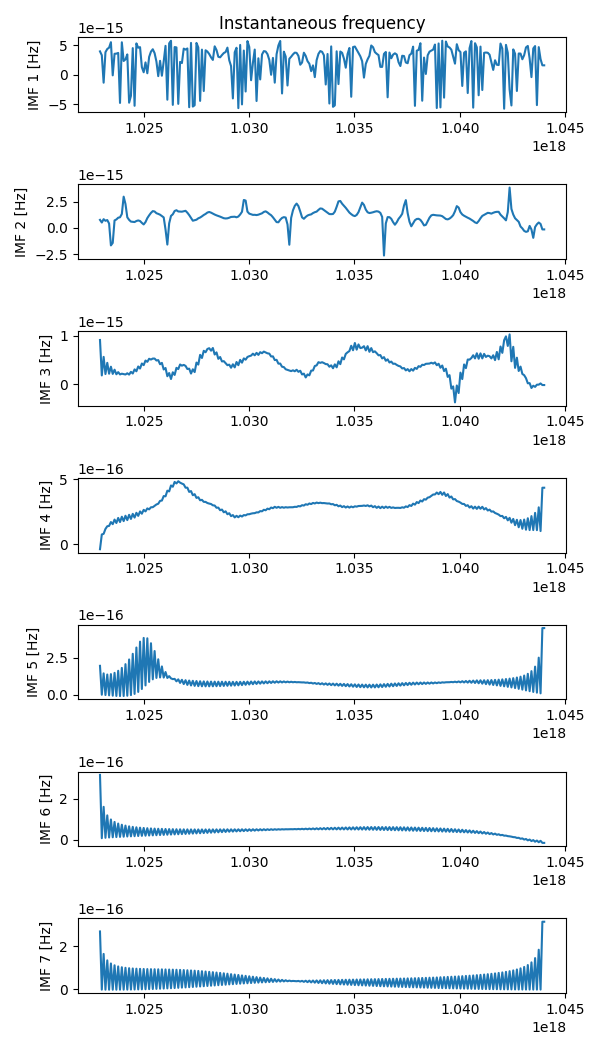

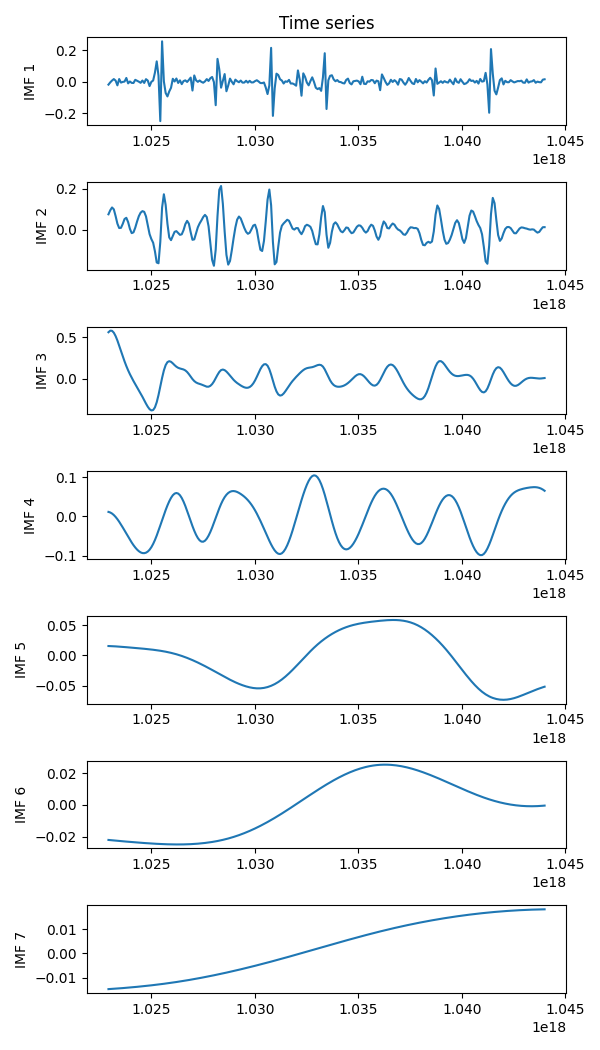

In [175]:
vis = Visualisation()
vis.plot_imfs(imfs=eIMFs, residue=res, t=t_float, include_residue=False)
vis.plot_instant_freq(t_float, imfs=eIMFs)
vis.show()

Text(0.5, 0, 'Time [s]')

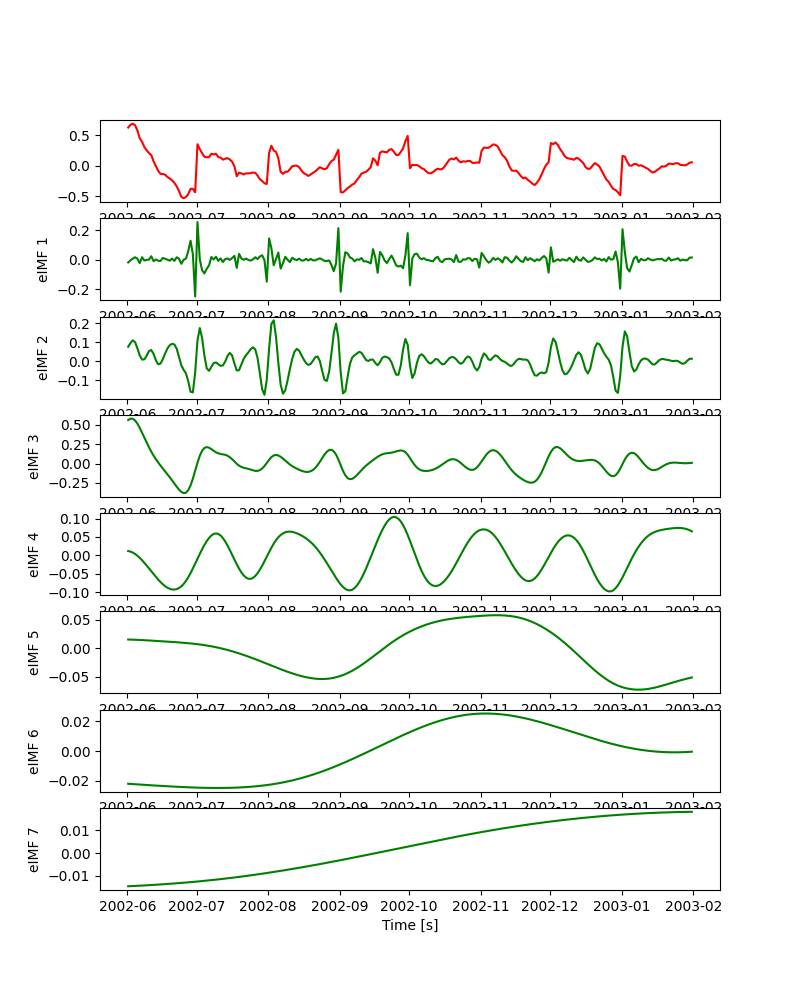

In [176]:
nIMFs = eIMFs.shape[0]
plt.figure(figsize=(8,10))
plt.subplot(nIMFs+1, 1, 1)

# plot original data
plt.plot(t, S, 'r')

# plot IMFs
for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")

In [93]:
# Extract statistical features from each EIMFs
mean_array = []
std_array = []
median_array = []
percentile25_array = []
percentile75_array = []

for imf in eIMFs:
    mean_array.append(np.mean(imf))
    std_array.append(np.std(imf))
    median_array.append(np.median(imf))
    percentile25_array.append(np.percentile(imf, 25))
    percentile75_array.append(np.percentile(imf, 75))

# After this cell, I have been experimenting how could I be able to use the statistical data out of IEMFs to use in a regression model, I was not successful yet. So please ignore if that makes confusing.

In [109]:
mean_array

[0.00017773213191183071,
 0.0012497282467701187,
 0.01213585479190476,
 -0.003793639234264329,
 -0.0042811046112984155,
 -0.0010304161600567059,
 0.006662527292723544]

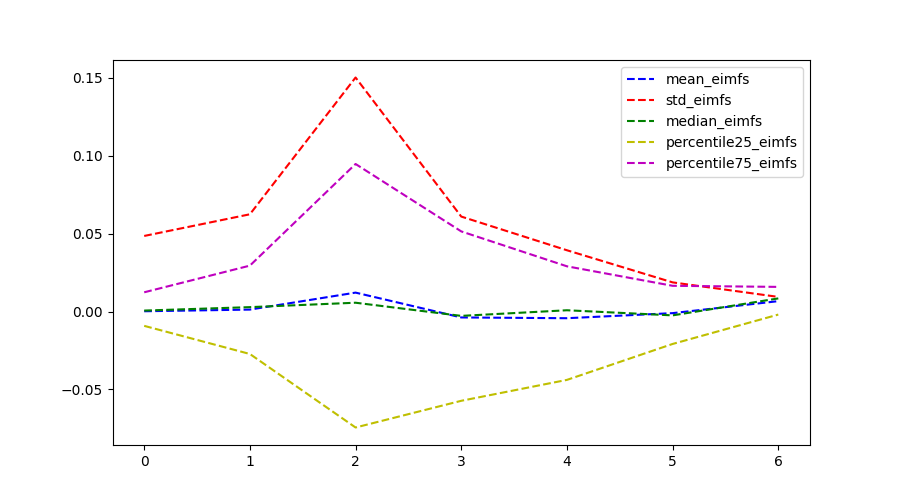

In [94]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(mean_array, '--b', label= 'mean_eimfs')
ax.plot(std_array, '--r', label= 'std_eimfs')
ax.plot(median_array, '--g', label= 'median_eimfs')
ax.plot(percentile25_array, '--y', label= 'percentile25_eimfs')
ax.plot(percentile75_array, '--m', label= 'percentile75_eimfs')
leg = ax.legend();

In [130]:
# array_feature
ds_sst_slice_median = ds_sst_slice.median(dim='time')

In [131]:
ds_sst_slice_median

<xarray.DataArray 'analysed_sst' (lat: 4001, lon: 4501)>
dask.array<nanmedian, shape=(4001, 4501), dtype=float32, chunksize=(322, 425), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -5.0 -4.99 -4.98 -4.97 ... 34.97 34.98 34.99 35.0
  * lon      (lon) float32 45.0 45.01 45.02 45.03 ... 89.97 89.98 89.99 90.0

In [132]:
prediction_horizon = 1  # Adjust as needed
target = ds_sst_slice_median.values[prediction_horizon:]

/env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [134]:
target.shape

(4000, 4501)

### running a simple regression model for prediction

In [96]:
# Create a DataFrame to hold the features and target to help in the prediction model run
feature_columns = ['mean', 'std', 'median', 'percentile25', 'percentile75']
features_df = pd.DataFrame({
    'mean': mean_array,
    'std': std_array,
    'median': median_array,
    'percentile25': percentile25_array,
    'percentile75': percentile75_array
})

In [135]:
# Reshape the target variable to align with the features
# num_samples, num_latitudes, num_longitudes = target.shape
# reshaped_target = target.reshape(num_samples, -1)
# reshaped_target.shape

In [136]:
# features_df

In [137]:
# Handle missing values in the target variable
# missing_indices = np.isnan(reshaped_target)
# missing_rows = missing_indices.any(axis=1)

In [138]:
# reshaped_target = reshaped_target[~missing_rows]

In [139]:
# reshaped_target.shape

In [140]:
# num_non_missing_rows = np.count_nonzero(~missing_rows)
# num_missing_rows = len(missing_rows) - num_non_missing_rows
# num_missing_rows
# features_df = features_df[~missing_indices]

In [183]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_df, target, test_size=0.2, shuffle=False
)

ValueError: Found input variables with inconsistent numbers of samples: [7, 244]